In [1]:
import pandas as pd
import numpy as np
from Models import HospitalModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('../../../Data/Hospital/Hospital.csv')
print(f"{len(dataset)} data points")

dataset.head()

17347 data points


,Date,City,Patients,Max,Min,Prec,Press,Wind,Insolat
0,2007-01-29,Bucuresti,472,10.6,-1.0,0.2,1003.8,22,7.9
1,2007-10-22,Bucuresti,503,12.2,4.6,9.7,1012.5,22,0.3
2,2007-01-03,Constanta,76,9.8,1.7,4.3,1006.3,24,0.9
3,2007-01-29,Constanta,71,9.8,-0.5,0.6,1003.8,23,5.2
4,2007-02-23,Constanta,94,1.9,-3.9,1.0,1016.7,20,0.4


In [3]:
X = dataset.drop(columns=['Patients'])
y = dataset['Patients']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=dataset['City'], shuffle=True)

# scale the columns: 
scaled_features = ["Max", "Min", "Prec", "Press", "Wind", "Insolat"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test[scaled_features])

## Experiments

**Experiment 1 - Importance of Algorithm**:
- Linear Regression
- Support Vector Regression
- KNN
- Decision Tree
- Random Forest
- XGBoost

**Experiment 2 - Importance Weather Data**:
- All features
- No weather features

In [4]:
search_space = {
    "algorithm": [LinearRegression, KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor],
    "data": ["all", "no-weather"],
}

drop_columns = {
    "all": [],
    "no-weather": ["Max", "Min", "Prec", "Press", "Wind", "Insolat"],
}

def run_experiments(search_space, drop_columns):
    results = {}
    for algorithm in tqdm(search_space["algorithm"], desc="Algorithm"):
        for data in search_space["data"]:

            model = HospitalModel(regressor=algorithm)

            _drop_columns = drop_columns[data]

            if data == "all":
                _X_train = X_train_scaled
                _X_test = X_test_scaled
            else:
                _X_train = X_train.drop(columns=_drop_columns)
                _X_test = X_test.drop(columns=_drop_columns)
                
            model.fit(_X_train, y_train)
            
            mae, mse = model.evaluate(_X_test, y_test, verbose=False)
            
            results[(algorithm.__name__, data)] = {
                "Mean Absolute Error": mae,
                "Mean Squared Error": mse,
            }

    impacts = []
    for algorithm in search_space["algorithm"]:
        all_mae = results[(algorithm.__name__, "all")]["Mean Absolute Error"]
        no_weather_mae = results[(algorithm.__name__, "no-weather")]["Mean Absolute Error"]
        if algorithm != DecisionTreeRegressor:
            impacts.append((no_weather_mae - all_mae) / no_weather_mae)

    return results, np.mean(impacts).round(3)

In [5]:
results, impact = run_experiments(search_space, drop_columns)
impact

Algorithm: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


-0.016

In [ ]:
results = pd.DataFrame(results).T.round(2)
results

Mean Absolute Error  Mean Squared Error
LinearRegression      all                       26.85             1643.68
                      no-weather                26.88             1648.16
KNeighborsRegressor   all                       22.73             1382.64
                      no-weather                22.45             1277.83
DecisionTreeRegressor all                       28.06             2077.09
                      no-weather                20.62             1080.74
RandomForestRegressor all                       21.03             1142.48
                      no-weather                20.62             1080.59
XGBRegressor          all                       21.38             1181.71
                      no-weather                20.62             1080.73

In [16]:
df = results["Mean Absolute Error"].reset_index().rename(columns={"level_0": "Algorithm", "level_1": "Features"})

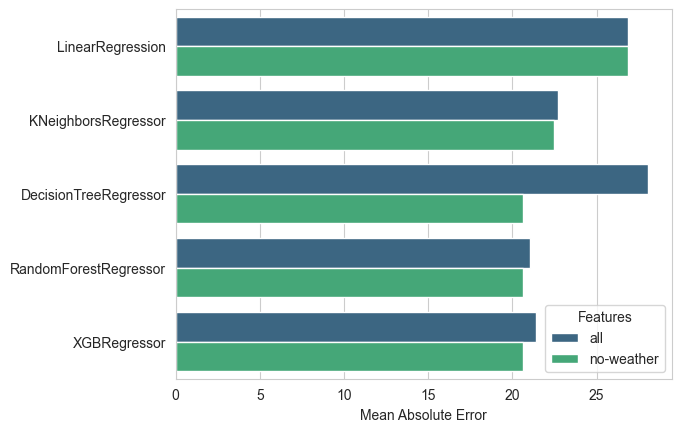

In [17]:
sns.set_style("whitegrid")

sns.barplot(data=df, y="Algorithm", hue="Features", x="Mean Absolute Error", palette="viridis", orient="h")
plt.legend(loc="lower right", title="Features")
plt.ylabel(None)
plt.show()